In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, Dropout,
                                     BatchNormalization, Input, Add, GlobalAveragePooling2D, Activation)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications.resnet50 import preprocess_input

In [2]:
def compute_dataset_mean_std(image_paths, input_size=224, sample_size=500):
    if sample_size < len(image_paths):
        indices = np.random.choice(len(image_paths), sample_size, replace=False)
        sample_paths = [image_paths[i] for i in indices]
    else:
        sample_paths = image_paths

    imgs = []
    for path in sample_paths:
        try:
            img = tf.io.read_file(path)
            img = tf.image.decode_image(img, channels=3)
            img = tf.image.resize(img, [input_size, input_size])
            img = tf.cast(img, tf.float32) / 255.0  # simple normalization for stats
            imgs.append(img)
        except Exception as e:
            print(f"Error processing {path}: {str(e)}")
    imgs = tf.stack(imgs)
    mu = tf.reduce_mean(imgs, axis=[0, 1, 2]).numpy()
    sigma = tf.math.reduce_std(imgs, axis=[0, 1, 2]).numpy()
    return mu, sigma

#############################################
# 2. Preprocessing Functions
#############################################
def resnet_preprocess(image):
    return preprocess_input(image)

def simple_normalize(image):
    return image / 255.0

def dataset_standardize(image, mu, sigma):
    image = image / 255.0
    return (image - mu) / sigma

#############################################
# 3. Custom Data Generator with Enhanced Augmentation and Debugging
#############################################
class CustomDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, X, Y, batch_size=8, input_size=224, shuffle=True,
                 data_aug=True, preprocessing_method='simple', mu=None, sigma=None,
                 debug=False, debug_max=3):
        """
        preprocessing_method: 'simple', 'resnet', or 'dataset'
        If 'dataset' is chosen, mu and sigma must be provided.
        """
        self.X = np.array(X)
        self.Y = np.array(Y)
        self.batch_size = batch_size
        self.IMG_SIZE = input_size
        self.shuffle = shuffle
        self.data_aug = data_aug
        self.preprocessing_method = preprocessing_method.lower()
        self.mu = mu
        self.sigma = sigma
        self.debug = debug
        self.debug_max = debug_max
        self.debug_counter = 0
        
        # Enhanced augmentation: add brightness and contrast changes.
        self.augmentation_pipeline = tf.keras.Sequential([
            tf.keras.layers.RandomFlip("horizontal"),
            tf.keras.layers.RandomRotation(0.1),
            tf.keras.layers.RandomZoom(0.1),
            tf.keras.layers.RandomTranslation(0.1, 0.1),
            # Additional augmentations can be added here.
        ])
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.ceil(len(self.X) / self.batch_size))
    
    def __img_preprocess(self, image_path):
        image = tf.io.read_file(image_path)
        image = tf.image.decode_image(image, channels=3)
        image = tf.image.resize(image, [self.IMG_SIZE, self.IMG_SIZE])
        image = tf.cast(image, tf.float32)  # [0,255]
        
        if self.data_aug:
            image = self.augmentation_pipeline(image)
        
        if self.preprocessing_method == 'resnet':
            image = resnet_preprocess(image)
        elif self.preprocessing_method == 'dataset':
            if self.mu is None or self.sigma is None:
                raise ValueError("For 'dataset' preprocessing, mu and sigma must be provided.")
            image = dataset_standardize(image, self.mu, self.sigma)
        else:
            image = simple_normalize(image)
        
        if self.debug and self.debug_counter < self.debug_max:
            img_np = image.numpy()
            print(f"Debug ({image_path}): shape={img_np.shape}, min={img_np.min():.4f}, max={img_np.max():.4f}, mean={img_np.mean():.4f}, std={img_np.std():.4f}")
            self.debug_counter += 1
        return image
    
    def __getitem__(self, idx):
        batch_x = self.X[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_y = self.Y[idx * self.batch_size : (idx + 1) * self.batch_size]
        return self.__get_data(batch_x, batch_y)
    
    def __get_data(self, x_batches, y_batches):
        X_batches = []
        Y_batches = []
        for x, y in zip(x_batches, y_batches):
            try:
                img = self.__img_preprocess(x)
                X_batches.append(img)
                Y_batches.append(y)
            except Exception as e:
                print(f"Error processing {x}: {str(e)}")
                continue
        return tf.stack(X_batches), tf.stack(Y_batches)
    
    def on_epoch_end(self):
        if self.shuffle:
            indices = np.random.permutation(len(self.X))
            self.X = self.X[indices]
            self.Y = self.Y[indices]
            self.debug_counter = 0



In [3]:
def create_label_encoder(dataset_path):
    classes = sorted(os.listdir(dataset_path))
    return {cls: [int(i == idx) for i in range(len(classes))]
            for idx, cls in enumerate(classes)}

In [4]:
def load_dataset(dataset_path: str, label_encode: dict):
    total_files = sum(len(files) for _, _, files in os.walk(dataset_path))
    x_data = np.empty(total_files, dtype=object)
    y_data = np.empty((total_files, len(label_encode)), dtype=int)
    index = 0
    for cur_class in os.listdir(dataset_path):
        temp_path = os.path.join(dataset_path, cur_class)
        for filename in os.listdir(temp_path):
            img_path = os.path.join(temp_path, filename)
            encoded_label = label_encode[cur_class]
            x_data[index] = img_path
            y_data[index] = encoded_label
            index += 1
    return x_data, y_data

In [5]:
base_path = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
train_path = os.path.join(base_path, "Datasets", "cats_and_dogs_filtered", "train")
test_path = os.path.join(base_path, "Datasets", "cats_and_dogs_filtered", "validation")


In [6]:
# Label encoding
label_encode = create_label_encoder(train_path)
print("Label encoding:", label_encode)

Label encoding: {'cats': [1, 0], 'dogs': [0, 1]}


In [7]:
x_train, y_train = load_dataset(train_path, label_encode)
x_test, y_test = load_dataset(test_path, label_encode)
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (2000,)
y_train shape: (2000, 2)
x_test shape: (1000,)
y_test shape: (1000, 2)


In [8]:
batch_size = 32
input_size = 224
input_shape = (224, 224, 3)

train_gen = CustomDataGenerator(X=x_train, Y=y_train, batch_size=batch_size,
                                input_size=input_size, shuffle=True, data_aug=True)
test_gen = CustomDataGenerator(X=x_test, Y=y_test, batch_size=batch_size,
                               input_size=input_size, shuffle=False, data_aug=False)

# Fetch one batch from the test generator to visualize a sample.
test_images, test_labels = next(iter(test_gen))
print("Sample test label (one-hot):", test_labels[0])
print("Sample test image shape:", test_images[0].shape)

Sample test label (one-hot): tf.Tensor([1 0], shape=(2,), dtype=int32)
Sample test image shape: (224, 224, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2121165..2.2764838].


Computed mu: [[[0.48172316 0.45274106 0.4142505 ]]]
Computed sigma: [[[0.25944254 0.25337976 0.2573045 ]]]
Debug (c:\Users\uhtin\OneDrive\Desktop\MLPROD\Datasets\cats_and_dogs_filtered\validation\cats\cat.2000.jpg): shape=(224, 224, 3), min=-1.2121, max=2.2765, mean=0.1482, std=0.8685
Debug (c:\Users\uhtin\OneDrive\Desktop\MLPROD\Datasets\cats_and_dogs_filtered\validation\cats\cat.2001.jpg): shape=(224, 224, 3), min=-1.3585, max=2.2765, mean=0.0554, std=1.0218
Debug (c:\Users\uhtin\OneDrive\Desktop\MLPROD\Datasets\cats_and_dogs_filtered\validation\cats\cat.2002.jpg): shape=(224, 224, 3), min=-1.8568, max=2.2765, mean=0.3987, std=1.1799
Overall sample batch stats:
Min: -1.8567624
Max: 2.2764838
Mean: 0.056770194
Std: 0.99036074


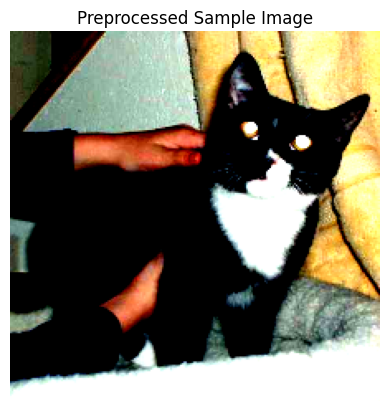

In [9]:
batch_size = 32
input_size = 224
input_shape = (224, 224, 3)

# Compute dataset-specific μ and σ.
sample_size = 500
mu, sigma = compute_dataset_mean_std(x_train, input_size=input_size, sample_size=sample_size)
mu = mu.reshape((1, 1, 3))
sigma = sigma.reshape((1, 1, 3))
print("Computed mu:", mu)
print("Computed sigma:", sigma)

# Choose preprocessing method: use 'dataset'
preprocessing_method = 'dataset'
train_gen = CustomDataGenerator(X=x_train, Y=y_train, batch_size=batch_size,
                                input_size=input_size, shuffle=True, data_aug=True,
                                preprocessing_method=preprocessing_method, mu=mu, sigma=sigma, debug=True)
test_gen = CustomDataGenerator(X=x_test, Y=y_test, batch_size=batch_size,
                               input_size=input_size, shuffle=False, data_aug=False,
                               preprocessing_method=preprocessing_method, mu=mu, sigma=sigma, debug=True)

# Check normalization on one batch.
sample_images, _ = next(iter(test_gen))
print("Overall sample batch stats:")
print("Min:", tf.reduce_min(sample_images).numpy())
print("Max:", tf.reduce_max(sample_images).numpy())
print("Mean:", tf.reduce_mean(sample_images).numpy())
print("Std:", tf.math.reduce_std(sample_images).numpy())

plt.imshow(sample_images[0].numpy(), cmap=None)
plt.axis("off")
plt.title("Preprocessed Sample Image")
plt.show()

In [10]:
def simple_residual_block(input_tensor, filters, strides=1):
    initializer = 'he_normal'
    x = Conv2D(filters, (3,3), strides=strides, padding='same', kernel_initializer=initializer)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, (3,3), padding='same', kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    
    if strides != 1 or int(input_tensor.shape[-1]) != filters:
        shortcut = Conv2D(filters, (1,1), strides=strides, padding='same', kernel_initializer=initializer)(input_tensor)
        shortcut = BatchNormalization()(shortcut)
    else:
        shortcut = input_tensor
        
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def build_small_resnet(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    initializer = 'he_normal'
    
    # Initial conv layer
    x = Conv2D(32, (3,3), padding='same', kernel_initializer=initializer)(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Residual blocks at 32 filters.
    x = simple_residual_block(x, 32)
    x = simple_residual_block(x, 32)
    x = MaxPooling2D((2,2))(x)
    
    # Residual blocks at 64 filters.
    x = simple_residual_block(x, 64, strides=2)
    x = simple_residual_block(x, 64)
    x = MaxPooling2D((2,2))(x)
    
    # Residual block at 128 filters.
    x = simple_residual_block(x, 128, strides=2)
    x = MaxPooling2D((2,2))(x)
    
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    return model

model = build_small_resnet(input_shape, 2)
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-3), metrics=['accuracy'])
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 224, 224, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [11]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)


In [12]:
epochs = 100
history = model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=epochs,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


Debug (c:\Users\uhtin\OneDrive\Desktop\MLPROD\Datasets\cats_and_dogs_filtered\train\dogs\dog.190.jpg): shape=(224, 224, 3), min=-1.7213, max=2.1856, mean=-0.4737, std=0.5492
Debug (c:\Users\uhtin\OneDrive\Desktop\MLPROD\Datasets\cats_and_dogs_filtered\train\dogs\dog.680.jpg): shape=(224, 224, 3), min=-1.6100, max=2.2353, mean=0.2556, std=1.0811
Debug (c:\Users\uhtin\OneDrive\Desktop\MLPROD\Datasets\cats_and_dogs_filtered\train\dogs\dog.844.jpg): shape=(224, 224, 3), min=-1.8568, max=2.2765, mean=0.0138, std=0.9394
Epoch 1/100
63/63 [==============================] - 44s 623ms/step - loss: 2.0508 - accuracy: 0.5655 - val_loss: 1.5971 - val_accuracy: 0.5220 - lr: 0.0010
Epoch 2/100
Debug (c:\Users\uhtin\OneDrive\Desktop\MLPROD\Datasets\cats_and_dogs_filtered\train\dogs\dog.524.jpg): shape=(224, 224, 3), min=-1.3675, max=2.2507, mean=0.4428, std=0.7331
Debug (c:\Users\uhtin\OneDrive\Desktop\MLPROD\Datasets\cats_and_dogs_filtered\train\dogs\dog.336.jpg): shape=(224, 224, 3), min=-1.8311, m